<a href="https://colab.research.google.com/github/soundrop199005/colabtest/blob/main/Level2_TrainModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is a simplified version of Level2 model training which wraps up the useful functions in Level2.ipynb with some examples

In [1]:
#General imports
from __future__ import print_function
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import progressbar
from __future__ import print_function
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
import gc
# Keras imports
import keras
import random
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.optimizers import *
from tensorflow.keras.utils import to_categorical
import keras.backend as K
import tensorflow as tf
# application (model) imports
from keras import applications
#from keras.applications.inception_v3 import preprocess_input
from keras.layers import Dense
import time
import math
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Wrap up a function to import Cifar10 dataset, and split training and validation.

In [2]:
# val_portion is the percentage of data you want to separate from the training set for validation purpose. Normally is 0.2 around.
# this function will return train images, train labels, validation images, validation labels in numpy arrays. All the labels are one hot encoded.

def prepare_train_val_data(val_portion):
  # downloading cifar data
  (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
  assert x_train.shape == (50000, 32, 32, 3)
  assert x_test.shape == (10000, 32, 32, 3)
  assert y_train.shape == (50000, 1)
  assert y_test.shape == (10000, 1)
  # one hot encoding
  print("First 5 training labels: ", y_train[:5])
  y_train = to_categorical(y_train, 10)
  y_test = to_categorical(y_test, 10)
  print("First 5 training lables as one-hot encoded vectors:\n", y_train[:5])
  print(y_train.shape)
  print(y_test.shape)
  trainX, valX, trainY, valY = train_test_split(x_train, y_train, test_size=val_portion, random_state=42, shuffle = True, stratify=y_train)
  [print(each.shape) for each in [trainX, trainY, valX, valY]]
  return trainX, trainY, valX, valY


In [3]:
# sample to have a look

def sample_show(x,y):
  # random generate a number from 0 to length-1
  index_sa = random.randint(0, len(y)-1)
  print(index_sa)
  plt.imshow(x[index_sa])
  print(y[index_sa])


Let's define a function to construct a new model. This new model removes the last 2 bottleneck blocks from the MobileNetV2 and output 10 classes in the final dense layer. I want hyperparameter
tuning the fully connected layer input units - original 1280 with the dropout. Also I want to add the weight decay.

In [4]:
# alp is the alpha - width multiplier in MobileNetV2 model architecture
# fc_units is the input size for the last fully connected layer
# fc_dropout is the dropout rate for the input units of the last fully connected layer
# weight_decay is the L2 norm alpha

# This function will output the model strucutre you customized and print the model summary out.

def new_model(alp,fc_units,fc_dropout,weight_decay) -> keras.Sequential:
  inputs = keras.Input(shape=(32, 32, 3))
  preprocess_input = applications.mobilenet_v2.preprocess_input
  x = preprocess_input(inputs)
  base_model_2 = applications.MobileNetV2(
  input_shape=(32,32,3),
  alpha=alp,
  include_top=True,
  weights= None,
  input_tensor=None,
  pooling=None,
  classes=10,
  classifier_activation="softmax")
  feature_extractor = keras.Model(base_model_2.input, base_model_2.layers[115].output)
  x_h = feature_extractor(x, training=True)
  x_c = keras.layers.Conv2D(filters = fc_units, kernel_size = 1, input_shape = x_h.shape[1:])(x_h)
  x_b = tf.keras.layers.BatchNormalization()(x_c)
  x_r = tf.keras.layers.ReLU()(x_b)
  x_a = tf.keras.layers.GlobalAveragePooling2D()(x_r)
  x_d = tf.keras.layers.Dropout(fc_dropout)(x_a)
  outputs = tf.keras.layers.Dense(10,activation='softmax')(x_d)
  model = tf.keras.Model(inputs, outputs)
  alpha = weight_decay  # weight decay coefficient
  for layer in model.layers:
      if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
          layer.add_loss(lambda: keras.regularizers.l2(alpha)(layer.kernel))
      if hasattr(layer, 'bias_regularizer') and layer.use_bias:
          layer.add_loss(lambda: keras.regularizers.l2(alpha)(layer.bias))
  print(model.summary())

  return model


This function is to plot the model training process

In [5]:
# history is the model training history retrieved
# filename is what you want to save the traing process graph as, which should be a valid directory

def plot_loss_accuracy_s(history,filename):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = min(history.history['val_loss'])
    mylist1 = history.history['val_loss']
    ind = mylist1.index(min(mylist1))
    acc =history.history['val_accuracy'][ind]
    plt.title('Val Loss: %.3f, Val Accuracy: %.3f' % (loss, acc))
    plt.savefig(filename)

Define a function for hyper parameter tuning more easily

In [6]:
# alp is the alpha - width multiplier in MobileNetV2 model architecture, around 1.
# lr is learning rate for model training
# m is momentum for model training
# wd is the L2 norm alpha for weight decay
# fc_u is the input size (the number of input units) for the last fully connected layer
# fc_d is the dropout rate for the input units of the last fully connected layer
# n_epoch is the maximum number of epochs you want to run. The model might be trained less epochs due to early stopping.
# directory is where you want to save your model to
# train_X is the training image numpy or tensor
# train_Y is the training labels in one hot encoder
# val_X is the validation image numpy or tensor
# val_Y is the validation labels in one hot encoder

# This function will train the model with your hyper parameter setting and save the best model during training into your folder.
# The model will be trained with your hyper parameter setting as listed above. Batch size is fixed to 64. Optimizer is RMSprop.
# It is a multiclassification problem. The last layer is activated by softmax. I used categorical cross entropy loss.
# During the training, the validation loss will be monitored. If the validation loss does not drop after 15 iterations, the model training stops automatically unless it reaches the maximum epochs earlier.
# The training process is saved into a graph. Under the folder you specified, you will see a png file called something like new_modelV2_alpha_%.3f_lr_%.9f_m_%.2f_wd_%.7f_fcu_%.1f_fcd_%.2f.png
# Only the best model during the training will be saved into a subfolder in h5 format. The sub folder name is something like new_modelV2_alpha_%.3f_lr_%.9f_m_%.2f_wd_%.7f_fcu_%.1f_fcd_%.2f
# This function returns the best model validation loss which you can use to compare among different models later for hyper parameter tuning purpose.

def hyp_tuning(alp, lr, m, wd,fc_u,fc_d,n_epoch, directory,train_X, train_Y,val_X,val_Y):
  # construct model
  model = new_model(alp,fc_u,fc_d,wd)
  # learning rate schedule
  lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=lr,
    decay_steps=50,
    decay_rate=0.98)
  # optimizer
  opt = tf.keras.optimizers.experimental.RMSprop(
      learning_rate=lr_schedule,
      rho=0.9,
      momentum=m,
      epsilon=1e-07,
      centered=False,
      # we used weight decay in the model by L2 norm instead
      weight_decay=0,
      clipnorm=None,
      clipvalue=None,
      global_clipnorm=None,
      use_ema=False,
      ema_momentum=0.99,
      ema_overwrite_frequency=100,
      jit_compile=True,
      name='RMSprop'
  )
  # callbacks
  parent_dir = os.path.join(directory, 'new_modelV2_alpha_%.3f_lr_%.9f_m_%.2f_wd_%.7f_fcu_%.1f_fcd_%.2f'%(alp,lr,m,wd,fc_u,fc_d))
  if not os.path.exists(parent_dir):
    os.mkdir(parent_dir)
  checkpoint_path = os.path.join(parent_dir, 'model.h5')
  print(checkpoint_path)
  my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='min'),
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min')]
  # compile model
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  # fit model
  history = model.fit(train_X, train_Y, validation_data=(val_X,val_Y), epochs=n_epoch, verbose=True, batch_size=64, shuffle=True,callbacks= my_callbacks)
  plot_loss_accuracy_s(history,parent_dir+'.png')
  return min(history.history['val_loss'])

A function to train the model with the best hyper parameter setting found so far from hyper parameter tuning

In [7]:
# dir is where you want to save your model to
# train_X is the training image numpy or tensor
# train_Y is the training labels in one hot encoder
# val_X is the validation image numpy or tensor
# val_Y is the validation labels in one hot encoder

# This function will train the model with the best hyper parameter setting found so far.
# It used early stopping with 50 maximum epochs.
# The training process graph will be saved into your directory.
# Only the best model during the training is saved into a sub folder in your defined folder.

def train_best(dir,trainX, trainY, valX, valY):
  alp = 0.9
  lr = 0.0001
  m = 0.9
  wd = 1e-05
  n_e = 50
  fc_u = 1000
  fc_d = 0.2
  hyp_tuning(alp, lr, m, wd, fc_u, fc_d, n_e, dir,trainX, trainY,valX,valY)


Let's try all these functions.
Firstly input data

In [8]:
trainX, trainY, valX, valY = prepare_train_val_data(0.2)

170498071/170498071 [==============================] - 6s 0us/step
First 5 training labels:  [[6]
 [9]
 [9]
 [4]
 [1]]
First 5 training lables as one-hot encoded vectors:
 [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
(50000, 10)
(10000, 10)
(40000, 32, 32, 3)
(40000, 10)
(10000, 32, 32, 3)
(10000, 10)


Have a look

2265
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


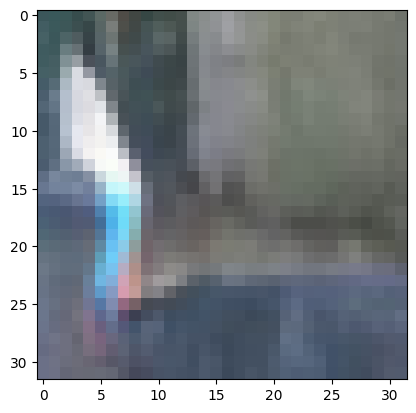

In [9]:
sample_show(trainX, trainY)

6784
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


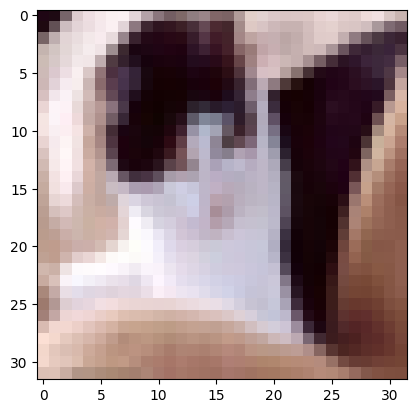

In [10]:
sample_show(valX, valY )

Build your customized models.  You can experiment more for hyper parameter tuning purpose.

In [11]:
cwd = os. getcwd()
print(cwd)

/content


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 32, 32, 3)         0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 32, 32, 3)         0         
 da)                                                             
                                                                 
 model (Functional)          (None, 2, 2, 112)         807872    
                                                                 
 conv2d (Conv2D)             (None, 2, 2, 1280)        144640    
                                                                 
 batch_normalization (Batch  (None, 2, 2, 1280)        5120

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 39s 20ms/step - loss: 1.8108 - accuracy: 0.3416 - val_loss: 1.4606 - val_accuracy: 0.4743
Epoch 2/100
625/625 [==============================] - 12s 19ms/step - loss: 1.3526 - accuracy: 0.5145 - val_loss: 1.2555 - val_accuracy: 0.5500
Epoch 3/100
625/625 [==============================] - 12s 19ms/step - loss: 1.1227 - accuracy: 0.6002 - val_loss: 1.1586 - val_accuracy: 0.5955
Epoch 4/100
625/625 [==============================] - 12s 19ms/step - loss: 0.9581 - accuracy: 0.6606 - val_loss: 1.1289 - val_accuracy: 0.6104
Epoch 5/100
625/625 [==============================] - 11s 18ms/step - loss: 0.8271 - accuracy: 0.7068 - val_loss: 1.1721 - val_accuracy: 0.6116
Epoch 6/100
625/625 [==============================] - 11s 18ms/step - loss: 0.7083 - accuracy: 0.7497 - val_loss: 1.2017 - val_accuracy: 0.6172
Epoch 7/100
625/625 [==============================] - 11s 18ms/step - loss: 0.6073 - accuracy: 0.7853 - val_loss: 1.2712 - val_accuracy: 0.61

1.128947377204895

<Figure size 800x600 with 0 Axes>

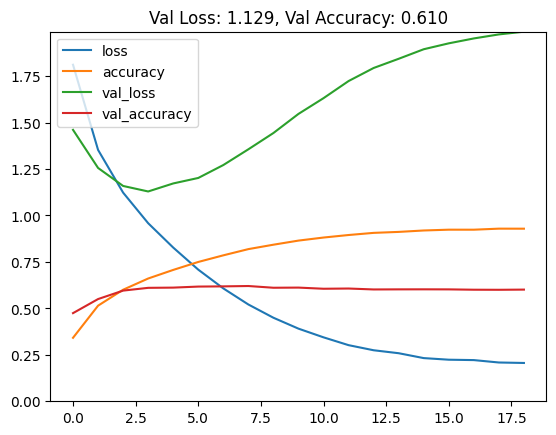

In [12]:
hyp_tuning(alp=1.2, lr = 0.00005, m =0.9, wd = 0.00002 ,fc_u = 1280,fc_d = 0.4 , n_epoch = 100,
               directory = cwd,
               train_X = trainX, train_Y = trainY, val_X = valX,val_Y = valY)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 32, 32, 3)         0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 32, 32, 3)         0         
 mbda)                                                           
                                                                 
 model_2 (Functional)        (None, 2, 2, 112)         807872    
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 1280)        144640    
                                                                 
 batch_normalization_1 (Bat  (None, 2, 2, 1280)        5120

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 29s 21ms/step - loss: 1.8488 - accuracy: 0.3346 - val_loss: 1.4532 - val_accuracy: 0.4714
Epoch 2/40
625/625 [==============================] - 12s 19ms/step - loss: 1.3727 - accuracy: 0.5041 - val_loss: 1.3026 - val_accuracy: 0.5393
Epoch 3/40
625/625 [==============================] - 12s 19ms/step - loss: 1.1535 - accuracy: 0.5881 - val_loss: 1.1994 - val_accuracy: 0.5704
Epoch 4/40
625/625 [==============================] - 12s 19ms/step - loss: 0.9956 - accuracy: 0.6440 - val_loss: 1.1640 - val_accuracy: 0.5853
Epoch 5/40
625/625 [==============================] - 11s 18ms/step - loss: 0.8617 - accuracy: 0.6941 - val_loss: 1.1736 - val_accuracy: 0.5991
Epoch 6/40
625/625 [==============================] - 12s 19ms/step - loss: 0.7441 - accuracy: 0.7376 - val_loss: 1.2356 - val_accuracy: 0.5965
Epoch 7/40
625/625 [==============================] - 12s 19ms/step - loss: 0.6455 - accuracy: 0.7720 - val_loss: 1.2774 - val_accuracy: 0.5978
Epo

1.1640037298202515

<Figure size 800x600 with 0 Axes>

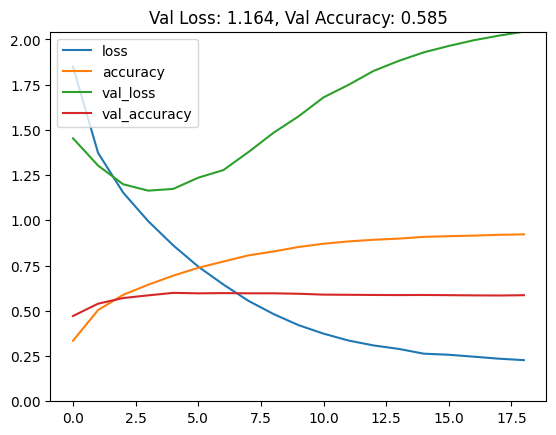

In [13]:
hyp_tuning(alp=1.2, lr = 0.00005, m =0.9, wd = 0.00004 ,fc_u = 1280,fc_d = 0.5 , n_epoch = 40,
               directory = cwd,
               train_X = trainX, train_Y = trainY, val_X = valX,val_Y = valY)

Train the model with the best hyper parameter setting found so far and save it into your target directory.

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 tf.math.truediv_2 (TFOpLam  (None, 32, 32, 3)         0         
 bda)                                                            
                                                                 
 tf.math.subtract_2 (TFOpLa  (None, 32, 32, 3)         0         
 mbda)                                                           
                                                                 
 model_4 (Functional)        (None, 2, 2, 88)          469056    
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 1000)        89000     
                                                                 
 batch_normalization_2 (Bat  (None, 2, 2, 1000)        4000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 30s 21ms/step - loss: 1.7042 - accuracy: 0.3715 - val_loss: 1.4364 - val_accuracy: 0.4866
Epoch 2/50
625/625 [==============================] - 13s 20ms/step - loss: 1.2720 - accuracy: 0.5428 - val_loss: 1.1733 - val_accuracy: 0.5816
Epoch 3/50
625/625 [==============================] - 12s 19ms/step - loss: 1.0733 - accuracy: 0.6183 - val_loss: 1.0869 - val_accuracy: 0.6189
Epoch 4/50
625/625 [==============================] - 12s 19ms/step - loss: 0.9320 - accuracy: 0.6675 - val_loss: 1.0478 - val_accuracy: 0.6323
Epoch 5/50
625/625 [==============================] - 12s 19ms/step - loss: 0.8218 - accuracy: 0.7099 - val_loss: 1.0513 - val_accuracy: 0.6401
Epoch 6/50
625/625 [==============================] - 12s 19ms/step - loss: 0.7264 - accuracy: 0.7415 - val_loss: 1.0409 - val_accuracy: 0.6540
Epoch 7/50
625/625 [==============================] - 12s 19ms/step - loss: 0.6386 - accuracy: 0.7747 - val_loss: 1.0685 - val_accuracy: 0.6527
Epo

<Figure size 800x600 with 0 Axes>

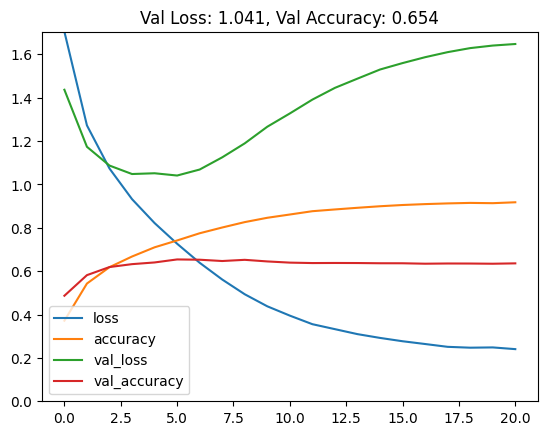

In [14]:
train_best(cwd, trainX, trainY, valX, valY)